<a href="https://colab.research.google.com/github/adeshsingh5505/BoilerEfficiency/blob/main/xgbOOst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

df = pd.read_csv('/content/data.csv')
df.info()
target_variable = 'TE_8332A.AV_0#'

df = df.drop(columns = ['date'])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

target_column = df[target_variable].values
window_size = 12
X_seq, X_lag, y = [], [], []

for i in range(window_size, len(scaled_data)):
    window = scaled_data[i - window_size:i]
    flat_window = window.flatten()
    X_seq.append(window)
    X_lag.append(flat_window)
    y.append(target_column[i])
X_seq = np.array(X_seq)
X_lag = np.array(X_lag)
y = np.array(y)
X_seq_train, X_seq_test, X_lag_train, X_lag_test, y_train, y_test = train_test_split(
    X_seq, X_lag, y, test_size=0.2, shuffle=False)
model_xgb = XGBRegressor(n_estimators=50)
model_xgb.fit(X_lag_train, y_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              86400 non-null  object 
 1   PT_8313A.AV_0#    86400 non-null  float64
 2   PT_8313B.AV_0#    86400 non-null  float64
 3   PT_8313C.AV_0#    86400 non-null  float64
 4   PT_8313D.AV_0#    86400 non-null  float64
 5   PT_8313E.AV_0#    86400 non-null  float64
 6   PT_8313F.AV_0#    86400 non-null  float64
 7   PTCA_8322A.AV_0#  86400 non-null  float64
 8   PTCA_8324.AV_0#   86400 non-null  float64
 9   TE_8319A.AV_0#    86400 non-null  float64
 10  TE_8319B.AV_0#    86400 non-null  float64
 11  TE_8313B.AV_0#    86400 non-null  float64
 12  TE_8303.AV_0#     86400 non-null  float64
 13  TE_8304.AV_0#     86400 non-null  float64
 14  TV_8329ZC.AV_0#   86400 non-null  float64
 15  FT_8301.AV_0#     86400 non-null  float64
 16  FT_8302.AV_0#     86400 non-null  float6

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
pred_xgb = model_xgb.predict(X_lag_test)

print('MAE of XGboost: ', mean_absolute_error(y_test,pred_xgb))
print('R2 of XGboost: ', r2_score(y_test,pred_xgb))

MAE of XGboost:  0.04552526831447552
R2 of XGboost:  0.9996349445622406


In [25]:
# Predict
y_pred = model_xgb.predict(X_lag_test)

# Absolute and percentage errors
absolute_error = np.abs(y_pred - y_test)
percentage_error = np.where(y_test != 0, (absolute_error / np.abs(y_test)) * 100, 0)

# Create DataFrame of results
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Absolute Error': absolute_error,
    'Percentage Error (%)': percentage_error
})

# Display first 10 predictions
print(results_df.head(10))

# Display min and max percentage error
max_err = np.max(percentage_error)
min_err = np.min(percentage_error)

print(f"\nMaximum Error Percentage: {max_err:.2f}%")
print(f"Minimum Error Percentage: {min_err:.2f}%")


   Actual   Predicted  Absolute Error  Percentage Error (%)
0  546.30  546.239014        0.060986              0.011164
1  546.17  546.275574        0.105574              0.019330
2  546.14  546.235107        0.095107              0.017414
3  546.07  546.191528        0.121528              0.022255
4  545.95  545.753174        0.196826              0.036052
5  545.85  545.834229        0.015771              0.002889
6  545.72  545.735962        0.015962              0.002925
7  545.62  545.565857        0.054143              0.009923
8  545.49  545.566406        0.076406              0.014007
9  545.27  545.540833        0.270833              0.049669

Maximum Error Percentage: 0.23%
Minimum Error Percentage: 0.00%


In [22]:
abs_error = np.abs(pred_xgb - y_test)
error_percent = (abs_error / np.abs(y_test)) * 100
mean_error_percent = np.mean(error_percent)
print(f"Mean Error Percentage: {mean_error_percent:.2f}%")

Mean Error Percentage: 0.01%


/tmp/ipython-input-35-3085198327.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


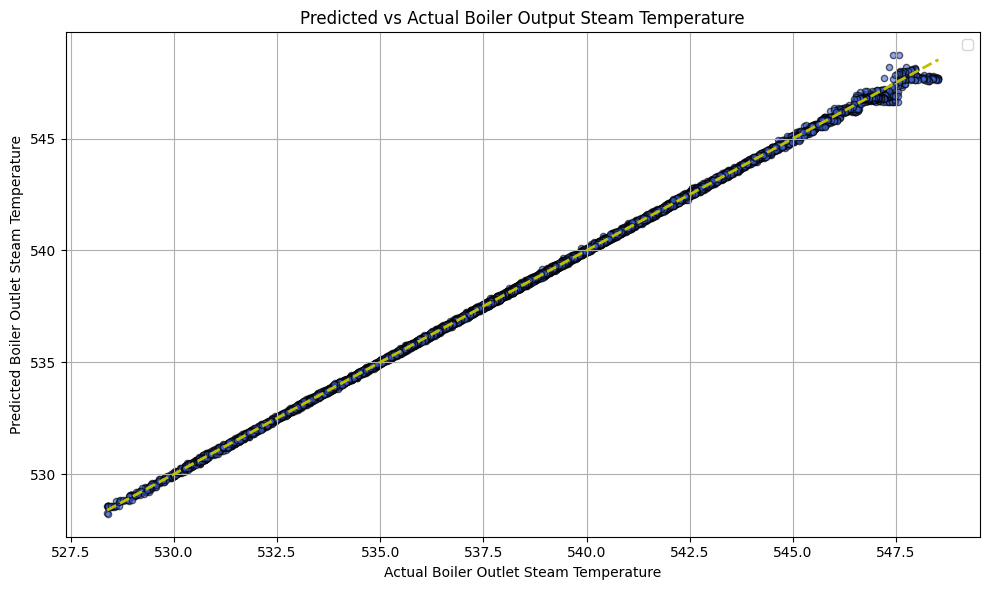

<Figure size 640x480 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred_xgb, s=20,alpha=0.6, color='royalblue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'y--', lw=2)  # 45-degree line
plt.title("Predicted vs Actual Boiler Output Steam Temperature")
plt.xlabel('Actual Boiler Outlet Steam Temperature')
plt.ylabel('Predicted Boiler Outlet Steam Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("predicted_vs_actual_scatter.png", dpi=300, bbox_inches='tight')